#Model 2: Skin Type Analyzer

This Model is Multiclass Classification Model with MobileNetV2 Transfer Learning and Fine-Tuning

## Import Libraries and Setup

This cell imports all the necessary libraries required for the machine learning model training pipeline, covering dataset preparation, model training, and evaluation. Below is the purpose of each library and module:

1. **Google Colab Integration**:
   - `drive` from `google.colab`: To connect Google Drive for accessing datasets and storing files.
   - `zipfile`: To extract ZIP files.
   - `os` and `shutil`: For file and folder manipulations in the file system.

2. **Data Preparation**:
   - `csv`: To read and write CSV files.
   - `train_test_split` from `sklearn.model_selection`: To split the dataset into training and testing sets.
   - `ImageDataGenerator` from `tensorflow.keras.preprocessing.image`: For data augmentation and image preprocessing.

3. **Model Development**:
   - `tensorflow` and its submodules:
     - `MobileNetV2`: A pre-trained model used as the base model for skin type detection.
     - `Model`, `Conv2D`, `MaxPooling2D`, etc.: To build and modify the model architecture.
     - `Adam`: An optimizer used for training the model.
     - `ReduceLROnPlateau` and `EarlyStopping`: Callbacks to control the training process and prevent overfitting.
     - `regularizers`: For adding regularization to reduce overfitting.

4. **Visualization and Analysis**:
   - `plot_model`: To visualize the model architecture.
   - `Image`: To display images in the notebook.
   - `matplotlib.pyplot` and `seaborn`: To create data visualizations and plots, such as confusion matrices and training curves.
   - `classification_report` and `confusion_matrix` from `sklearn.metrics`: To evaluate the model's performance and generate detailed classification metrics.

5. **Utility Functions**:
   - `sys` and `numpy`: For data manipulation and mathematical operations.
   - `pandas`: For table-based data manipulation and analysis.
   - `load_img`, `img_to_array`: To load and convert images into arrays for model training.

These libraries will be used throughout the pipeline to train a skin type detection model using MobileNetV2 as the base model.


In [10]:
from google.colab import drive
import zipfile
import os
import csv
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import random
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
import sys
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Data Preprocessing

### Mount Google Drive

This cell is responsible for mounting Google Drive to the Colab environment. By mounting the drive, we can access the datasets and save the model or results directly to Google Drive. The `force_remount=True` argument ensures that the drive is remounted even if it has been mounted previously.

- `drive.mount('/content/drive', force_remount=True)`: This command mounts the user's Google Drive at the specified path (`/content/drive`), allowing access to files stored in the drive during the training process.


In [2]:
# Mount google drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Data Retrieve and Balancing

#### Define the Paths

In this cell, we define the paths to the dataset and the destination directory where the dataset will be extracted.

- `zip_path`: This is the path to the ZIP file containing the skin type dataset located on Google Drive.
- `destination_path`: This is the directory where the dataset will be extracted to on the local Colab environment.

These paths will be used in the following steps for extracting the dataset and preparing it for model training.

In [6]:
# Define the paths
zip_path = "/content/drive/MyDrive/Capstone Project /Machine Learning/SkinTypesDataset.zip"
destination_path = "/content/SkinTypes"

#### Check and Extract ZIP File

This cell checks whether the ZIP file containing the dataset exists at the specified path, and if it does, it extracts the contents to the destination directory.

- **File Existence Check**:
  - `os.path.exists(zip_path)`: This checks if the ZIP file exists at the specified `zip_path` on Google Drive.
  
- **Extraction**:
  - If the file exists, the code uses `zipfile.ZipFile` to open and extract the contents of the ZIP file into the local directory specified by `destination_path`.
  - `zip_ref.extractall(destination_path)`: This extracts all the contents of the ZIP file to the destination folder.

- **Error Handling**:
  - If the ZIP file is not found, it prints a message indicating that the file does not exist at the specified path.

This step ensures that the dataset is properly extracted and ready for use in the model training process.


In [7]:
# Periksa apakah file ZIP ada
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destination_path)
    print(f"File berhasil diekstrak ke: {destination_path}")
else:
    print(f"File ZIP tidak ditemukan di: {zip_path}")

File berhasil diekstrak ke: /content/SkinTypes


#### Count Images in Each Class Folder

This cell counts the number of image files in each subfolder of the dataset, which represents different skin types. The script iterates over each class (skin type), checks if the corresponding folder exists, and counts the number of image files within that folder.

- **Dataset Directory**:
  - `dataset_dir`: This is the path to the directory where the skin type dataset has been extracted.
  
- **Class Folders**:
  - `classes`: A list of subfolders representing different skin types (`combination`, `dry`, `normal`, `oily`).
  
- **Folder Check and Image Count**:
  - The code checks if each class folder exists using `os.path.exists(folder_path)`.
  - If the folder exists, it counts the number of image files in that folder by iterating over the files with `os.listdir(folder_path)` and using `os.path.isfile()` to filter out non-image files.
  - The number of image files is printed for each class.

- **Error Handling**:
  - If a class folder is not found, a message is printed indicating that the folder does not exist.

This step provides an overview of the dataset by reporting how many images are available for each skin type class.


In [8]:
# Path ke folder baru
dataset_dir = "/content/SkinTypes"

# Hitung jumlah file di setiap subfolder
classes = ["combination", "dry", "normal", "oily"]
for cls in classes:
    folder_path = os.path.join(dataset_dir, cls)
    if os.path.exists(folder_path):
        file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        print(f"{cls}: {file_count} images")
    else:
        print(f"Folder {cls} not found.")

combination: 1476 images
dry: 1634 images
normal: 2403 images
oily: 2409 images


#### Undersample Class Data

This cell defines and calls a function `undersample_class` that performs undersampling on a specific class directory by reducing the number of images to a desired target count. This is useful when the dataset is imbalanced and you want to limit the number of images in certain classes.

##### Function: `undersample_class`

The function reduces the number of files in the `source_dir` to the specified `target_count` by randomly moving excess files to the `target_dir`.

###### Parameters:
- `source_dir (str)`: Path to the source directory containing the images of a particular skin type (e.g., `/content/SkinTypes/combination`).
- `target_dir (str)`: Path to the directory where the excess files will be moved.
- `target_count (int)`: Desired number of files to keep in the `source_dir` after undersampling.

###### Steps:
1. **Directory Creation**:
   - If the `target_dir` does not exist, it is created using `os.makedirs()`.
  
2. **File Listing**:
   - The function lists all the files in the `source_dir` using `os.listdir()`.
  
3. **Undersampling Validation**:
   - If the number of files in the source directory is already less than or equal to the `target_count`, a message is printed and no files are moved.
  
4. **Random Selection**:
   - The function randomly selects `target_count` files from the `source_dir` using `random.sample()`.
  
5. **File Movement**:
   - Files that are not selected are moved to the `target_dir` using `shutil.move()`.

6. **Completion Message**:
   - Once the undersampling is complete, a message is printed indicating how many files were moved.

###### Usage:
- The function is called for the `combination` class in the dataset, with `1400` as the target count for the number of images to retain. The remaining excess images are moved to a temporary folder (`combin_temp`).

This step ensures that the number of images in each class is balanced and can help mitigate issues related to class imbalance during model training.


In [11]:
def undersample_class(source_dir, target_dir, target_count):
    """
    Reduces the number of files in the source_dir to the target_count by randomly moving excess files to the target_dir.

    Parameters:
        source_dir (str): Path to the source directory containing the original data
                          (e.g., /content/SkinTypesV2/combination).
        target_dir (str): Path to the directory where the excess files will be moved.
        target_count (int): Desired number of files to keep in the source directory after undersampling.

    Returns:
        None
    """
    # Create the target directory if it does not exist
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # List all files in the source directory
    all_files = os.listdir(source_dir)

    # Validate if undersampling is necessary
    if len(all_files) <= target_count:
        print("The number of files is already equal to or less than the target_count. No files were moved.")
        return

    # Randomly select files to retain in the source directory
    selected_files = random.sample(all_files, target_count)

    # Move the remaining files to the target directory
    for file in all_files:
        file_path = os.path.join(source_dir, file)
        if file not in selected_files:
            shutil.move(file_path, target_dir)

    print(f"Undersampling completed. {len(all_files) - target_count} files have been moved to {target_dir}.")

# Usage
source_paths = ['/content/SkinTypes/combination']
target_paths = ['/content/SkinTypes/combin_temp']

# Iterate through the lists of paths
for source_path, target_path in zip(source_paths, target_paths):
    undersample_class(source_path, target_path, 1400) # Call the function for each pair of paths

Undersampling completed. 76 files have been moved to /content/SkinTypes/combin_temp.


#### Undersample Multiple Class Data

These cells call the `undersample_class` function for multiple skin type classes (`dry`, `oily`, and `normal`) to ensure each class has an equal number of images. The function is used to undersample the classes by moving excess images to a temporary folder.

##### Process Overview:
- The `undersample_class` function is applied to the following classes: `dry`, `oily`, and `normal`.
- For each class, excess files are moved from the original directory to a temporary directory (`combin_temp`).
- The target number of images for each class is set to `1400`.

##### Class-wise Undersampling:
1. **Dry Skin**:
   - `source_path`: `/content/SkinTypes/dry`
   - `target_path`: `/content/SkinTypes/combin_temp`
   - The function reduces the number of files in the `dry` folder to 1400 by moving excess images to the target folder.

2. **Oily Skin**:
   - `source_path`: `/content/SkinTypes/oily`
   - `target_path`: `/content/SkinTypes/combin_temp`
   - Similarly, the function reduces the `oily` folder to 1400 images.

3. **Normal Skin**:
   - `source_path`: `/content/SkinTypes/normal`
   - `target_path`: `/content/SkinTypes/combin_temp`
   - The function ensures that the `normal` skin class has 1400 images.

These steps help ensure that the dataset is balanced across different skin types, which can improve the performance of the model during training.

In [12]:
source_paths = ['/content/SkinTypes/dry']
target_paths = ['/content/SkinTypes/combin_temp']

# Iterate through the lists of paths
for source_path, target_path in zip(source_paths, target_paths):
    undersample_class(source_path, target_path, 1400)

Undersampling completed. 234 files have been moved to /content/SkinTypes/combin_temp.


In [13]:
source_paths = ['/content/SkinTypes/oily']
target_paths = ['/content/SkinTypes/combin_temp']

# Iterate through the lists of paths
for source_path, target_path in zip(source_paths, target_paths):
    undersample_class(source_path, target_path, 1400) # Call the function for each pair of paths

Undersampling completed. 1009 files have been moved to /content/SkinTypes/combin_temp.


In [14]:
source_paths = ['/content/SkinTypes/normal']
target_paths = ['/content/SkinTypes/combin_temp']

# Iterate through the lists of paths
for source_path, target_path in zip(source_paths, target_paths):
    undersample_class(source_path, target_path, 1400) # Call the function for each pair of paths

Undersampling completed. 1003 files have been moved to /content/SkinTypes/combin_temp.


#### Remove Temporary Folder

This cell removes the temporary folder (`combin_temp`) that was used to store the excess images during the undersampling process.

- `!rm -rf "/content/SkinTypes/combin_temp"`: This command deletes the `combin_temp` directory and all of its contents. The `-rf` flag is used to forcefully remove the folder and its contents without confirmation.

This step is typically performed after the undersampling process is complete to clean up unnecessary files and free up storage.


In [15]:
!rm -rf "/content/SkinTypes/combin_temp"

#### Re-check Image Count in Each Class Folder

This cell re-checks the number of image files in each class folder after the undersampling process to confirm the final count of images in each class.

##### Steps:
- **Directory Setup**:
  - `rev_dir`: This is the path to the main directory where the skin type classes (`combination`, `dry`, `normal`, `oily`) are stored.
  
- **Class Folders**:
  - `classes`: A list of subfolders representing different skin types.
  
- **Image Counting**:
  - The code checks each class folder to count the number of image files using `os.listdir()` and `os.path.isfile()`.
  
- **Folder Check**:
  - If a folder exists, it counts the number of image files and prints the result for each class.
  - If a folder does not exist, it prints a message indicating the missing folder.

This step helps confirm the final number of images per class after the undersampling process.


In [16]:
# Path ke folder baru
rev_dir = "/content/SkinTypes"

# Hitung jumlah file di setiap subfolder
classes = ["combination", "dry", "normal", "oily"]
for cls in classes:
    folder_path = os.path.join(rev_dir, cls)
    if os.path.exists(folder_path):
        file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        print(f"{cls}: {file_count} images")
    else:
        print(f"Folder {cls} tidak ditemukan.")


combination: 1400 images
dry: 1400 images
normal: 1400 images
oily: 1400 images


#### Rename Files in Each Class Folder

This cell renames all the image files in each skin type class folder to a standardized format: `class_name_index.jpg`. This ensures that the files follow a consistent naming convention, which can be useful for organizing and referencing files during model training.

##### Process Overview:
1. **Dataset Path**:
   - `final_dataset`: This is the path to the main directory where all the skin type class folders are stored (`/content/SkinTypes`).
   
2. **Class Folders**:
   - The code iterates over each folder in `final_dataset`, where each folder corresponds to a skin type class (e.g., `combination`, `dry`, `normal`, `oily`).
   
3. **File Renaming**:
   - For each file in a class folder, the code generates a new name in the format: `class_name_index.jpg`. For example, `combination_1.jpg`, `dry_2.jpg`, etc.
   - `os.rename(old_file_path, new_file_path)` is used to rename the files.

4. **File Check**:
   - Before renaming, the code checks if the item is a file using `os.path.isfile()` to avoid errors related to subdirectories or non-image files.

5. **Completion**:
   - After renaming all files, the process is marked as complete with the message `Renaming complete!`.

This step ensures that all image files in the dataset are consistently named, making it easier to work with them in later stages of model training.

In [17]:
# Path ke dataset final
final_dataset = "/content/SkinTypes"

# Merename file di setiap kelas
for class_name in os.listdir(final_dataset):
    class_path = os.path.join(final_dataset, class_name)
    if os.path.isdir(class_path):  # Pastikan hanya memproses folder
        print(f"Renaming files in class: {class_name}")
        for idx, file_name in enumerate(os.listdir(class_path), start=1):
            old_file_path = os.path.join(class_path, file_name)
            # Format nama baru: class_name_1.jpg, class_name_2.jpg, ...
            new_file_name = f"{class_name}_{idx}.jpg"
            new_file_path = os.path.join(class_path, new_file_name)

            # Check if old_file_path is a file before renaming
            if os.path.isfile(old_file_path):
                os.rename(old_file_path, new_file_path)
            else:
                print(f"Skipping {old_file_path} as it is not a file.")

print("Renaming complete!")

Renaming files in class: oily
Renaming files in class: dry
Renaming files in class: combination
Renaming files in class: normal
Renaming complete!


### Generate CSV File for Image Labels

This cell creates a CSV file that associates each image in the dataset with its corresponding label (skin type). The CSV file contains two columns: `file` and `label`, where `file` is the name of the image file and `label` is the skin type associated with that image.

### Process Overview:
1. **Class List**:
   - `skintype_classes`: This list contains the skin type class names (`combination`, `dry`, `normal`, `oily`).

2. **CSV File Setup**:
   - `output_csv`: The path to the CSV file where image filenames and their corresponding skin type labels will be saved (`/content/SkinTypes/skin_type_labels.csv`).
   - The CSV file is opened in write mode, and the header row `['file', 'label']` is written to the file.

3. **Iterating Over Classes**:
   - For each skin type class in `skintype_classes`, the code iterates through the folder containing the images (`combination`, `dry`, `normal`, `oily`).

4. **Writing Data to CSV**:
   - For each image file in a class folder, the code writes the image filename and the associated skin type to the CSV file.
   - The format is: `[image_filename, skin_type]`.

5. **Completion**:
   - After processing all images, the message `Labelling completed, data saved to skin_type_labels.csv.` is printed to indicate the successful creation of the CSV file.

This step provides a structured label file (`skin_type_labels.csv`) that can be used for training the machine learning model, where each image is paired with its label.

In [18]:
# Daftar kelas (folder)
skintype_classes = ['combination', 'dry', 'normal', 'oily']
base_path = '/content/SkinTypes'
# Membuat file CSV untuk mencatat label
output_csv = os.path.join(base_path, 'skin_type_labels.csv')
with open(output_csv, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['file', 'label'])  # Header

    # Iterasi tiap kelas dan menulis data ke CSV
    for skintype in skintype_classes:
        skintype_folder = os.path.join(base_path, skintype)
        for img_file in os.listdir(skintype_folder):
            writer.writerow([img_file, skintype])
print("Labelling completed, data saved to skin_type_labels.csv.")

Labelling completed, data saved to skin_type_labels.csv.


### Split Dataset into Train, Validation, and Test Sets

This cell splits the image dataset into three parts: **training**, **validation**, and **test** sets. The images are distributed proportionally among these sets with the following ratios:
- **80%** for training
- **10%** for validation
- **10%** for testing

### Process Overview:
1. **Directories Setup**:
   - `train_path`, `val_path`, and `test_path`: Paths are defined to store the training, validation, and test datasets, respectively. The directories are created using `os.makedirs()` if they do not already exist.

2. **Class List**:
   - `skintype_classes`: A list of the skin type classes (`combination`, `dry`, `normal`, `oily`).

3. **Splitting Dataset**:
   - For each skin type class, the images are listed using `os.listdir()`, and the dataset is split into training, validation, and test sets using `train_test_split()` from `sklearn.model_selection`.
   - **80%** of the images are assigned to the training set, **10%** to the validation set, and **10%** to the test set.

4. **Class-Specific Directories**:
   - For each class (`combination`, `dry`, `normal`, `oily`), subdirectories are created under `train`, `validation`, and `test` folders to store the images for each dataset split.

5. **Moving Images**:
   - The images are moved from their original class folder to the appropriate subdirectory (`train`, `validation`, or `test`) using `shutil.move()`.

6. **Completion**:
   - After processing all classes, a message is printed to show the number of images moved into each set for each class.
   - The final message, `Spliting success to train, validation, and test.`, is printed to indicate the successful splitting of the dataset.

This step ensures that the dataset is properly organized and ready for training the machine learning model with a balanced distribution of images across training, validation, and test sets.

In [19]:
# Direktori dataset
dataset_path = '/content/SkinTypes'
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'validation')
test_path = os.path.join(dataset_path, 'test')

# Daftar kelas

skintype_classes = ['combination', 'dry', 'normal', 'oily']

# Membuat direktori train, validation, test
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Split dataset secara proporsional untuk setiap kelas
for types in skintype_classes:
    class_dir = os.path.join(dataset_path, types)
    images = os.listdir(class_dir)

    # Menghitung proporsi split (80% train, 10% val, 10% test)
    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Membuat subdirektori untuk setiap kelas
    train_class_dir = os.path.join(train_path, types)
    val_class_dir = os.path.join(val_path, types)
    test_class_dir = os.path.join(test_path, types)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Memindahkan gambar ke folder yang sesuai
    for img in train_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(train_class_dir, img))
    for img in val_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(val_class_dir, img))
    for img in test_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(test_class_dir, img))

    print(f"Class {types} finished: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

print("Spliting success to train, validation, and test.")


Class combination finished: Train=1120, Val=140, Test=140
Class dry finished: Train=1120, Val=140, Test=140
Class normal finished: Train=1120, Val=140, Test=140
Class oily finished: Train=1120, Val=140, Test=140
Spliting success to train, validation, and test.


### Create Data Generators for Train, Validation, and Test Sets

This cell sets up the data generators for loading and augmenting images from the **training**, **validation**, and **test** directories. The data generators handle the process of data augmentation (for training) and normalization (for validation and testing), which are essential for feeding the data into the model during training.

### Process Overview:
1. **Data Augmentation for Training Set**:
   - `train_datagen`: An instance of `ImageDataGenerator` with several data augmentation techniques applied:
     - **Rescaling**: The pixel values are scaled to the range `[0, 1]` by dividing by `255`.
     - **Rotation**: Random rotation within a range of 30 degrees.
     - **Width and Height Shift**: Random shifts of up to 20% in both width and height.
     - **Shearing**: Random shearing transformations.
     - **Zoom**: Random zoom within a range of 30%.
     - **Horizontal Flip**: Random horizontal flips.
     - **Brightness Range**: Random changes to brightness between 80% and 120%.
     - **Fill Mode**: Pixels that are rotated or shifted are filled with the nearest value.

2. **Normalization for Validation and Test Sets**:
   - `val_test_datagen`: Another instance of `ImageDataGenerator`, but only with **rescaling** applied for validation and test sets, to scale pixel values to `[0, 1]`.

3. **Training Data Generator**:
   - `train_generator`: The generator for the training set, which loads images from the training directory (`train_dir`), resizes them to 224x224 pixels, and applies data augmentation.

4. **Validation and Test Data Generators**:
   - `val_generator`: The generator for the validation set, which loads images from the validation directory (`val_dir`) and resizes them to 224x224 pixels.
   - `test_generator`: The generator for the test set, which loads images from the test directory (`test_dir`) and resizes them to 224x224 pixels. The `shuffle=False` parameter ensures that the images are not shuffled, preserving the order for evaluation.

5. **Return Generators**:
   - The function returns three generators: `train_generator`, `val_generator`, and `test_generator`, which can be used to train and evaluate the model.

6. **Completion**:
   - The message `Data generators siap digunakan.` is printed to indicate that the generators are ready to be used for model training and evaluation.

This step ensures that the image data is loaded efficiently, with proper augmentation and normalization applied to improve the model's performance.

In [20]:
def create_data_generators(train_dir, val_dir, test_dir):
    # Data augmentation untuk training set
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )


    # Normalisasi untuk validation dan test set
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Generator untuk training set
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # Generator untuk validation set
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    # Generator untuk test set
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

# Membuat generator
train_generator, val_generator, test_generator = create_data_generators(
    train_path, val_path, test_path
)

print("Data generators siap digunakan.")

Found 4480 images belonging to 4 classes.
Found 560 images belonging to 4 classes.
Found 560 images belonging to 4 classes.
Data generators siap digunakan.


## Build the Model

In this cell, a Convolutional Neural Network (CNN) is built by using **MobileNetV2** as the base model, followed by custom layers to suit the skin type classification task.

### Model Architecture:
1. **Base Model (MobileNetV2)**:
   - **MobileNetV2** is used as the feature extractor (base model) with pre-trained weights from ImageNet. It is chosen for its efficient architecture, especially for mobile and edge devices.
   - The top layers of MobileNetV2 are excluded by setting `include_top=False`, which allows us to add custom layers on top.
   - The input shape is set to `(224, 224, 3)` for RGB images of size 224x224.
   - The base model is frozen by setting `base_model.trainable = False`, meaning its weights will not be updated during training.

2. **Custom Layers**:
   - **GlobalAveragePooling2D**: Applied to reduce the spatial dimensions of the feature maps produced by MobileNetV2, resulting in a 1D vector per image.
   - **Dense Layer (256 units)**: A fully connected layer with 256 neurons and `ReLU` activation, followed by L2 regularization to prevent overfitting.
   - **BatchNormalization**: Normalizes the activations to stabilize and accelerate training.
   - **Dropout (0.6)**: Dropout is applied with a rate of 60% to reduce overfitting by randomly setting 60% of the neurons to zero during training.
   - **Dense Layer (32 units)**: Another fully connected layer with 32 neurons and `ReLU` activation, followed by batch normalization and a 50% dropout rate.
   - **Output Layer (4 classes)**: A dense output layer with 4 neurons (one for each skin type class), using the `softmax` activation function to output class probabilities.

3. **Compilation**:
   - The model is compiled using the **Adam optimizer** with a learning rate of `0.0001` for fine-tuning.
   - The loss function used is **categorical cross-entropy**, which is appropriate for multi-class classification.
   - The metric for evaluation is **accuracy**, which will be tracked during training.

The model is now ready to be trained on the dataset for skin type classification.

In [ ]:
# Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(4, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Model Summary and Visualization

This cell defines a function `model_summary` that provides a summary of the model's architecture and visualizes it as an image.

### Function Breakdown:
- **`model_summary(model)`**:
  - **`model.summary()`**: Prints a detailed summary of the model architecture, including the type and shape of each layer, the number of parameters, and the total number of parameters in the model.
  - **`plot_model()`**: Generates a visual representation of the model architecture. The diagram is saved as 'model.jpg' with the following parameters:
    - **`show_shapes=True`**: Displays the shapes of the inputs and outputs for each layer.
    - **`show_dtype=True`**: Displays the data type of the layer outputs.
    - **`rankdir='TB'`**: Specifies the direction of the diagram (top-to-bottom).
    - **`dpi=150`**: Sets the resolution of the saved diagram to 150 DPI.
    - **`show_layer_activations=True`**: Highlights the activations of each layer.

This function is used to gain a better understanding of the model's architecture and visualize the entire network for easy reference.
\

In [21]:
def model_summary(model):
  print(f"Model Summary:\n{model.summary()}")
  plot_model(
      model,
      to_file='model.jpg',
      show_shapes=True,
      show_dtype=True,
      rankdir='TB',
      dpi=150,
      show_layer_activations=True
  )

In [22]:
model_summary(model)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,595,430 (9.90 MB)

 Trainable params: 1,542,948 (5.89 MB)

 Non-trainable params: 1,052,480 (4.01 MB)

 Optimizer params: 2 (12.00 B)

Model Summary:
None
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.729615 to fit



## Fine-Tuning and Callbacks

This cell is used for fine-tuning the model by unfreezing some layers of the base model and setting up callbacks to monitor the training process.

### Fine-Tuning:
- **Unfreezing Layers**:
  - The last 20 layers of the base model (`MobileNetV2`) are unfrozen to allow them to be trainable. This enables the model to learn more complex patterns specific to the skin type classification task, while keeping the earlier layers frozen to preserve the features learned from the pre-trained weights.
  - **Code**:
    ```python
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    ```

### Callbacks:
Callbacks are used to adjust the learning rate and stop training early if necessary to prevent overfitting or unnecessary training.

- **`ReduceLROnPlateau`**:
  - Monitors the validation loss (`val_loss`), and reduces the learning rate by a factor of 0.2 if the loss plateaus for 3 epochs. This helps the model converge better after reaching a plateau.
  - **Parameters**:
    - **`monitor='val_loss'`**: Tracks the validation loss.
    - **`factor=0.2`**: Reduces the learning rate by 80% when triggered.
    - **`patience=3`**: Waits for 3 epochs before reducing the learning rate.
    - **`min_lr=1e-6`**: Specifies the minimum learning rate.
    - **`verbose=1`**: Displays a message when the learning rate is reduced.

- **`EarlyStopping`**:
  - Stops the training if the validation loss does not improve for 5 consecutive epochs. It restores the model to the best weights observed during training to avoid overfitting.
  - **Parameters**:
    - **`monitor='val_loss'`**: Tracks the validation loss.
    - **`patience=5`**: Waits for 5 epochs before stopping.
    - **`restore_best_weights=True`**: Restores the best weights when training stops.
    - **`verbose=1`**: Displays a message when training stops.

These strategies help improve training efficiency and prevent overfitting by adjusting the learning rate dynamically and stopping training early when further improvements are unlikely.


In [ ]:
# Unfreeze some layers of the base model (fine-tuning)
for layer in base_model.layers[-20:]:
    layer.trainable = True
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

## Training the Model

In this section, the model is trained using the training and validation datasets with the defined callbacks to optimize performance.

### Training Setup:
- **Training Data**: The model is trained using the `train_generator`, which provides the augmented images for the training set.
- **Validation Data**: The `val_generator` is used for validating the model's performance during training.
- **Epochs**: The training will run for a maximum of 100 epochs, though early stopping may halt training earlier if validation performance does not improve.
- **Callbacks**:
  - `reduce_lr`: Reduces the learning rate when the validation loss plateaus.
  - `early_stop`: Stops training early if there is no improvement in the validation loss for 5 consecutive epochs.

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 113s 615ms/step - accuracy: 0.2664 - loss: 7.0626 - val_accuracy: 0.3250 - val_loss: 6.2881 - learning_rate: 1.0000e-04
Epoch 2/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 128s 613ms/step - accuracy: 0.3129 - loss: 6.7358 - val_accuracy: 0.3875 - val_loss: 6.2187 - learning_rate: 1.0000e-04
Epoch 3/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 135s 566ms/step - accuracy: 0.3333 - loss: 6.5418 - val_accuracy: 0.3911 - val_loss: 5.9826 - learning_rate: 1.0000e-04
Epoch 4/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 143s 559ms/step - accuracy: 0.3496 - loss: 6.3424 - val_accuracy: 0.4143 - val_loss: 5.9077 - learning_rate: 1.0000e-04
Epoch 5/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 560ms/step - accuracy: 0.3475 - loss: 6.1964 - val_accuracy: 0.4304 - val_loss: 5.8774 - learning_rate: 1.0000e-04
Epoch 6/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 82s 554ms/step - accuracy: 0.3897 - loss: 5.9741 - val_accuracy: 0.4607 - val_loss: 5.5650 - learning_rate: 1.0000e-04
Epoch 7/100
140/140 ━━━━━━━━━━━━━━━━━━━━ 81s 556

## Evaluate the Model

### Evaluate the Model on the Test Set

This cell evaluates the model’s performance on the test set using the `evaluate` method. It computes the loss and accuracy based on the test data provided by the `test_generator`.

#### Evaluation Process:
- **STEP_SIZE_TEST**:
  - `STEP_SIZE_TEST` is calculated as the total number of test samples (`test_generator.n`) divided by the batch size (`test_generator.batch_size`). This determines how many steps (batches) the model should process to complete the evaluation.
  
- **Resetting the Generator**:
  - `test_generator.reset()` is called to ensure that the generator starts from the beginning before evaluating the model. This is necessary if the generator has already been used for any prior operations.
  
- **Model Evaluation**:
  - The `model.evaluate()` function is used to compute the test loss and test accuracy based on the test data. The number of steps is provided by `steps=STEP_SIZE_TEST`.

#### Output:
- **Test Loss**: The loss value computed on the test set.
- **Test Accuracy**: The accuracy metric computed on the test set.

This step is important for assessing the final model's performance on unseen data, which provides an estimate of how well the model will generalize to new, real-world data.


In [ ]:
# Evaluate on test set
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator, steps=STEP_SIZE_TEST)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.9191 - loss: 0.5855
Test Loss: 0.7264
Test Accuracy: 0.8805


### Plot Training and Validation Accuracy and Loss

This cell generates plots to visualize the model's performance during training, including both the training and validation accuracy, as well as the training and validation loss, for each epoch.

#### Accuracy Plot:
- **Training Accuracy**: The accuracy of the model on the training set is plotted in red (`'r'`).
- **Validation Accuracy**: The accuracy of the model on the validation set is plotted in blue (`'b'`).
- The plot displays how the model's accuracy improves over epochs for both the training and validation sets.

#### Loss Plot:
- **Training Loss**: The loss during training is plotted in red (`'r'`).
- **Validation Loss**: The loss during validation is plotted in blue (`'b'`).
- This plot shows how the model’s loss decreases over time, which is expected as the model learns from the data.

#### Plot Details:
- The `epochs` variable represents the number of epochs.
- `history.history['accuracy']` and `history.history['val_accuracy']` contain the accuracy values for training and validation, respectively.
- `history.history['loss']` and `history.history['val_loss']` contain the loss values for training and validation, respectively.
  
The plots allow you to visually assess the model's learning progress and identify potential issues like overfitting or underfitting. If the validation loss increases while training loss decreases, it may indicate overfitting.

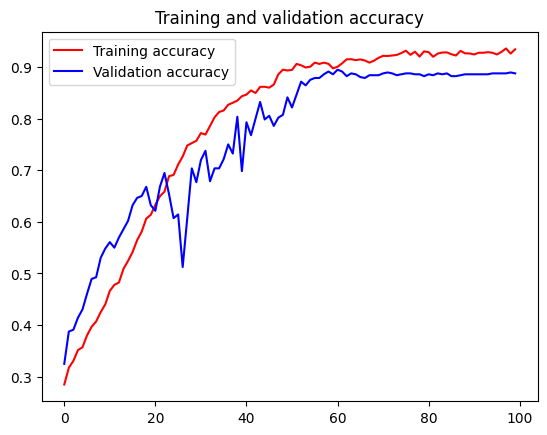

<Figure size 640x480 with 0 Axes>

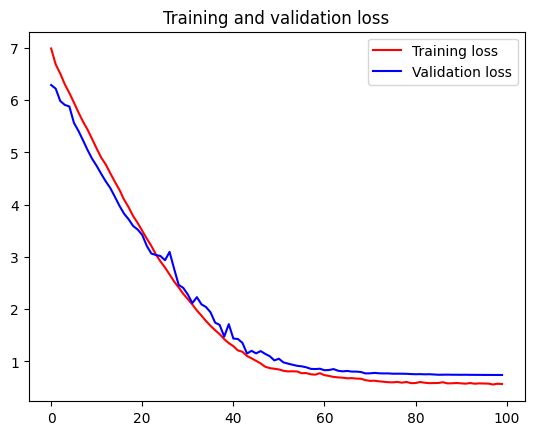

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

### Model Evaluation: Classification Report, Confusion Matrix, and Save Results

This cell evaluates the model's performance on the test set by generating a classification report and confusion matrix. It also saves the results to a file.

#### Classification Report:
- **True Labels and Predicted Labels**:
  - For each batch in the test set (`test_generator`), the true labels (`y_true`) and predicted labels (`y_pred_classes`) are collected.
  - The predictions are generated by the model using `model.predict()`, and the classes with the highest probabilities are selected using `np.argmax()`.

- **Classification Report**:
  - The `classification_report` function from `sklearn` is used to compute various performance metrics, such as precision, recall, F1-score, and accuracy for each class in `SKIN_CLASSES` (the disease classes).
  - The report is printed to show how well the model performs on each class.

#### Confusion Matrix:
- A confusion matrix is computed using `confusion_matrix` from `sklearn` to show the model’s predictions against the true labels.
- The matrix is visualized using a heatmap generated by `seaborn` (`sns.heatmap`), where the x-axis represents predicted classes, and the y-axis represents true classes.
- The confusion matrix is saved as a PNG file (`'confusion_matrix_skintypes.png'`).

#### Saving Evaluation Results:
- The test set's evaluation results (loss and accuracy) are saved into a CSV file (`'evaluation_results_skintypes.csv'`).
- This allows you to keep a record of the model's performance on the test data.

#### Output:
- **Classification Report**: Displays precision, recall, and F1-score for each class.
- **Confusion Matrix**: A heatmap visualizing the true vs. predicted class distributions.
- **Evaluation Results**: The loss and accuracy are saved to a CSV file for further analysis.

This step is essential for assessing how well the model generalizes to the test data and provides insights into areas where the model might need improvement, such as specific disease classes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

 combination       0.95      0.99      0.97       140
         dry       0.89      0.97      0.93       140
      normal       0.93      0.89      0.91       140
        oily       0.95      0.86      0.91       140

    accuracy                           0.93       560
   

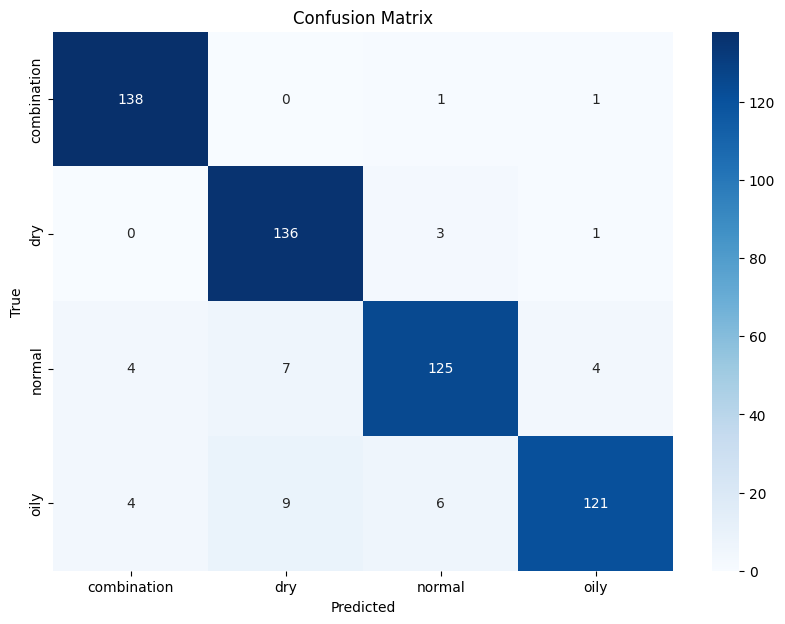

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Confusion matrix saved as 'confusion_matrix_skintypes.png'
Evaluation results saved as 'evaluation_results_skintypes.csv'


In [23]:
SKIN_CLASSES=['combination', 'dry', 'normal', 'oily']
y_true=[]
y_pred_classes=[]
for i in range(len(test_generator)):
  test_subset = test_generator[i]
  y_true.extend(np.argmax(test_subset[1], axis=1))
  y_pred = model.predict(test_subset[0])
  y_pred_classes.extend(np.argmax(y_pred, axis=1))

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=SKIN_CLASSES))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7 ))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=SKIN_CLASSES, yticklabels=SKIN_CLASSES, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_skintypes.png')
plt.show()

evaluation_results = model.evaluate(test_generator, verbose=0)
evaluation_df = pd.DataFrame([evaluation_results], columns=['Loss', 'Accuracy'])
evaluation_df.to_csv('evaluation_results_skintypes.csv', index=False)

print("Confusion matrix saved as 'confusion_matrix_skintypes.png'")
print("Evaluation results saved as 'evaluation_results_skintypes.csv'")

### Save Model Summary to a Text File

This cell saves the summary of the model architecture to a text file (`model_summary.txt`) for documentation purposes.

#### Process:
- The `model.summary()` function is called to generate a summary of the model's architecture, including information about the layers, their output shapes, number of parameters, and other details.
- To capture the summary and save it to a file, the standard output (`sys.stdout`) is redirected to the file `model_summary.txt`.
  
#### Error Handling:
- If there is any issue generating the summary (e.g., an exception occurs), it is caught, and an error message is written to the file instead.
- Additionally, if there is an error while saving the summary to the text file (e.g., due to file permission issues), it is caught and displayed.

#### Output:
- The model's architecture summary is saved in `model_summary.txt`.
- If the operation is successful, a message is printed confirming that the summary has been saved.
- In case of errors, appropriate error messages are displayed.

This is useful for saving the model's structure for later reference, sharing, or reviewing the architecture in detail.


In [24]:
try:
  with open('model_summary.txt', 'w') as m:
    stdout_m = sys.stdout
    sys.stdout = m

    try:
      model.summary()
    except Exception as n:
      print(f"Error while generating summary: {n}")
    finally:
      sys.stdout = stdout_m
  print("Model summary saved in model_summary.txt")
except IOError as n:
  print(f"Error occured when saving model summary: {n}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,595,430 (9.90 MB)

 Trainable params: 1,542,948 (5.89 MB)

 Non-trainable params: 1,052,480 (4.01 MB)

 Optimizer params: 2 (12.00 B)

Model summary saved in model_summary.txt


## Copy Notebook to a Specific Folder

This cell copies the current notebook (`SkinTypeModel.ipynb`) to a designated folder on Google Drive for organization or backup purposes.

### Process:
- The notebook file is copied from its current location (`notebook_name`) to a target folder (`folder_path`) using the `cp` command.
- The paths are defined using variables `notebook_name` and `folder_path`, which point to the notebook and the destination folder, respectively.

### Output:
- The notebook file is successfully copied to the specified folder.
- If the copy operation is successful, no additional output is shown, but the notebook is now located in the target folder (`SkinDisease`).

This step is useful for backing up the current notebook, organizing project files, or preparing the notebook for sharing or further work in a specific folder.


In [ ]:
notebook_name = "/content/drive/MyDrive/Colab Notebooks/SkinTypeModel.ipynb"
folder_path = "/content/drive/MyDrive/Capstone Project /Machine Learning/SkinTypes"
!cp "{notebook_name}" "{folder_path}"

## Save the Trained Model

This cell saves the trained model to a file for future use, enabling you to reload the model without needing to retrain it.

### Steps:
- The `model.save('model_skin_type.h5')` function is used to save the entire trained model (architecture, weights, and training configuration) into a file named `model_skin_type.h5`.
- The saved model can later be loaded using `tf.keras.models.load_model()` to continue from where training left off or for inference purposes.

### Output:
- The model is saved as a `.h5` file, which includes:
  - The architecture of the model.
  - The weights learned during training.
  - The optimizer configuration, if any.
  - The model's state for resuming training or for inference.

This step is crucial for preserving the trained model and reusing it without retraining from scratch.

In [ ]:
model.save('model_skin_type.h5')

### Copy the Saved Model to Google Drive

This cell copies the saved model (`model_skin_disease.h5`) from the current working directory to a specified folder in Google Drive.

#### Steps:
- The `!cp model_skin_disease.h5 '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease'` command is used to copy the model file.
- The source path is the current directory where the model is saved (`model_skin_disease.h5`).
- The destination path is the specified folder in Google Drive (`/content/drive/MyDrive/Capstone Project /Machine Learning/SkinDisease`).

#### Output:
- The model file is copied to the designated folder in Google Drive for storage, backup, or sharing purposes.

This step ensures that the trained model is stored in a safe location and can be accessed or reused later from Google Drive.

In [ ]:
!cp -r '/content/SkinTypes' "/content/drive/MyDrive/Capstone Project /Machine Learning"

In [ ]:
!cp 'model_skin_type.h5' '/content/drive/MyDrive/Capstone Project /Machine Learning/SkinTypes'

## Load the Model

This cell loads a previously trained model from a saved `.h5` file to continue the evaluation, fine-tuning, or inference process.

#### Process:
- The `tf.keras.models.load_model()` function is used to load the model from the specified file path (`'/content/drive/MyDrive/Capstone Project /Machine Learning/SkinType/model_skin_type.h5'`).
- The loaded model can then be used for further tasks such as prediction, evaluation, or fine-tuning, without having to retrain it from scratch.

#### Output:
- The model is loaded into memory and is now available for further use. There is no output generated by this operation, but you can interact with the `model` object thereafter (e.g., use it for predictions, evaluation, etc.).

This step is crucial for reusing a trained model that has been saved previously, enabling further testing, deployment, or continued training.

In [3]:
!cp "/content/drive/MyDrive/Capstone Project /Machine Learning/SkinTypes/model_skin_type.h5" "/content/model_skin_type.h5"

In [4]:
import tensorflow as tf

# Load model .h5
model = tf.keras.models.load_model("/content/model_skin_type.h5")

## Model Prediction Testing Using Confidence Level

This cell demonstrates how to predict the skin type of a given image using the trained model. The main steps include:

1. **Function `predict_image`**:
   - **Input**: The file path of the image (`image_path`) to be predicted.
   - **Process**:
     - Loads the image and resizes it to the specified `input_shape` (224x224 pixels with 3 color channels).
     - Converts the image into a numerical array and adds a batch dimension.
     - Normalizes the pixel values by dividing them by 255.
     - Uses the trained model to make predictions on the processed image.
     - Maps the predicted indices to their corresponding class labels.
   - **Output**: Predicted class labels and their confidence levels for each class.

2. **Example Prediction**:
   - The example uses the image path `/content/SkinTypes/test/combination/combination_104.jpg` (you can replace this with your desired image path).
   - The prediction results are printed in the format:
     - Skin type (class label).
     - Confidence level as a percentage (%).

**Notes**:
- Ensure that the `model` and `train_generator` are properly defined earlier in the notebook.
- Replace `image_path` with the path to the image you want to test.


In [ ]:
# Predict example image
input_shape = (224, 224, 3)

def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension
    img_array /= 255.0  # Normalize pixel values

    prediction = model.predict(img_array)
    labels = train_generator.class_indices
    labels = dict((v, k) for k, v in labels.items())

    predicted_labels = []
    confidence_levels = []
    for idx, val in enumerate(prediction[0]):
        predicted_labels.append(labels[idx])
        confidence_levels.append(val)

    return predicted_labels, confidence_levels

# Example prediction
image_path = '/content/SkinTypes/test/combination/combination_104.jpg'  # Replace with your image path
predictions, confidences = predict_image(image_path)

for i in range(len(predictions)):
    print(f"Type skin: {predictions[i]} | Confidence: {confidences[i] * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Type skin: combination | Confidence: 99.85%
Type skin: dry | Confidence: 0.07%
Type skin: normal | Confidence: 0.04%
Type skin: oily | Confidence: 0.04%


## Convert Trained Model to TFLite Format

This cell demonstrates how to convert the trained TensorFlow model to TFLite format for deployment on edge devices or mobile applications. The steps are as follows:

1. **Model Conversion**:
   - The `TFLiteConverter` is used to convert the trained TensorFlow Keras model (`model`) into a TFLite model.
   - The converted model is stored in the variable `tflite_model`.

2. **Saving the TFLite Model**:
   - The TFLite model is saved to a file named `model_skin_type.tflite` in the current working directory.
   - The file is written in binary mode using Python's `open` function.

**Notes**:
- Ensure that the `model` has been properly trained and defined in the previous steps.
- The TFLite model can now be used in mobile or embedded systems for efficient inference.


In [ ]:
# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open("model_skin_type.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmps1fyoltv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138631245425200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631209916320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631209917200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631209911744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631209914032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631209919840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631209920192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631209921424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631209918080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631209919488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138631209923888

### Copy TFLite Model to Google Drive

This cell is used to copy the saved TFLite model file from the local Colab environment to a specified folder in Google Drive. The steps are as follows:

1. **Source File**:
   - The TFLite model file (`model_skin_type.tflite`) is located in the Colab directory `/content/`.

2. **Destination Path**:
   - The file is copied to the folder `/content/drive/MyDrive/Capstone Project/Machine Learning/SkinTypes` in Google Drive.

3. **Command**:
   - The `!cp` command is a shell command used to copy files in the Linux environment.

**Notes**:
- Ensure that Google Drive is mounted in the Colab environment before running this command.
- Replace the destination path with your desired folder in Google Drive, if necessary.
- This step allows you to safely store and access the TFLite model later.

In [ ]:
!cp "/content/model_skin_type.tflite" "/content/drive/MyDrive/Capstone Project /Machine Learning/SkinTypes"

## TFLITE Model Predict

### Load and Run Inference with TFLite Model

This cell demonstrates how to load a TFLite model and use it to make predictions on input images. The steps include:

1. **Loading the TFLite Model**:
   - The TFLite model is loaded from the specified path (`tflite_model_path`) using TensorFlow's `tf.lite.Interpreter`.
   - The interpreter allocates the necessary tensors to enable inference.

2. **Getting Model Input and Output Details**:
   - `input_details` contains information about the input tensor, including its shape and index.
   - `output_details` provides information about the output tensor.

3. **Defining the `predict_image_tflite` Function**:
   - **Inputs**:
     - `image_path`: Path to the image to be predicted.
     - `labels`: A list of class labels corresponding to the model output indices.
   - **Steps**:
     1. Resizes the image to match the input shape required by the TFLite model.
     2. Converts the image to a numerical array, adds a batch dimension, and normalizes pixel values to the range [0, 1].
     3. Sets the processed image data as the input tensor for the TFLite interpreter.
     4. Invokes the interpreter to perform inference.
     5. Retrieves the prediction results (confidence levels) from the output tensor.
   - **Outputs**:
     - `predicted_labels`: List of predicted class labels.
     - `confidence_levels`: Corresponding confidence levels for each label.

**Notes**:
- Replace the `tflite_model_path` with the path to your TFLite model file.
- Ensure the `labels` list is defined and matches the classes in your dataset.
- This function is specifically designed for single image inference. Batch inference requires additional modifications.


In [ ]:
import tensorflow as tf
import numpy as np

# Load TFLite model
tflite_model_path = "/content/model_skin_type.tflite"  # Ganti dengan path ke model TFLite kamu
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Dapatkan detail tensor input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Fungsi untuk memprediksi gambar
def predict_image_tflite(image_path, labels):
    input_shape = input_details[0]['shape'][1:3]  # Ambil ukuran input dari model

    # Load dan preprocess gambar
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
    img_array = img_array / 255.0  # Normalisasi piksel (0-1)

    # Masukkan data ke input tensor
    interpreter.set_tensor(input_details[0]['index'], img_array)

    # Jalankan inferensi
    interpreter.invoke()

    # Ambil hasil prediksi dari output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])[0]

    # Ambil label dan confidence
    predicted_labels = []
    confidence_levels = []
    for idx, confidence in enumerate(output_data):
        predicted_labels.append(labels[idx])
        confidence_levels.append(confidence)

    return predicted_labels, confidence_levels

### Map Labels and Perform Prediction with TFLite Model

This cell demonstrates how to map class indices to their corresponding labels and perform predictions on a test image using the TFLite model.

1. **Mapping Labels**:
   - A dictionary `labels` is created to map the model's output indices to the corresponding class labels:
     - `0: "Combination"`
     - `1: "Dry"`
     - `2: "Normal"`
     - `3: "Oily"`

2. **Specifying Test Image**:
   - The `image_path` variable specifies the path to the image to be tested. In this example, it points to a sample image (`normal_1225.jpg`) stored in Google Drive.

3. **Making Predictions**:
   - The `predict_image_tflite` function is called with the test image path and the label mapping.
   - The function returns:
     - `predictions`: List of predicted class labels.
     - `confidences`: List of confidence levels for each prediction.

4. **Displaying Results**:
   - The prediction results are printed in the format:
     - Skin type (class label).
     - Confidence level as a percentage (%).

**Notes**:
- Ensure that the `predict_image_tflite` function is defined and the TFLite model has been successfully loaded before running this cell.
- Replace the `image_path` with the path to your own test image if necessary.
- The confidence levels provide insights into the model's certainty for each predicted class.

In [ ]:
# Mapping labels (seperti pada train_generator.class_indices)
labels = {
    0: "Combination",
    1: "Dry",
    2: "Normal",
    3: "Oily"
}

# Ganti dengan path ke gambar yang ingin diuji
image_path = "/content/drive/MyDrive/Capstone Project /Machine Learning/SkinTypes/test/normal/normal_1225.jpg"

# Prediksi gambar
predictions, confidences = predict_image_tflite(image_path, labels)

# Tampilkan hasil prediksi
for i in range(len(predictions)):
    print(f"Type skin: {predictions[i]} | Confidence: {confidences[i] * 100:.2f}%")


Type skin: Combination | Confidence: 0.04%
Type skin: Dry | Confidence: 0.19%
Type skin: Normal | Confidence: 99.63%
Type skin: Oily | Confidence: 0.15%
